In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
import ast

### 1. 

In [25]:
# Importing the dataset
train_data = pd.read_csv('./Data/train.csv',parse_dates=['host_since', 'first_review', 'last_review'])
train_target = train_data['price'] 
train_data = train_data.drop('price', axis = 1)

test_data = pd.read_csv('./Data/test.csv',parse_dates=['host_since', 'first_review', 'last_review'])
test_id = test_data['id']
test_data = test_data.drop('id', axis = 1)

print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15696 entries, 0 to 15695
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   name                                          15696 non-null  object        
 1   description                                   15309 non-null  object        
 2   property_type                                 15696 non-null  object        
 3   neighbourhood_cleansed                        15696 non-null  object        
 4   neighbourhood_group_cleansed                  15696 non-null  object        
 5   latitude                                      15696 non-null  float64       
 6   longitude                                     15696 non-null  float64       
 7   host_since                                    15696 non-null  datetime64[ns]
 8   host_response_time                            13493 non-null  obje

#### 1.1  Delete obviously usless features and error data. 

##### Useless features:

In [26]:
# drop the name column
train_data = train_data.drop('name', axis=1)
test_data = test_data.drop('name', axis=1)

##### The abnormal data in the dataset. 

There are host that possess calculated_host_listings_count = [876, 719, 354, 330], majority of them don't have any review and have availability for 365. These data are probably fake or error data.

In [27]:
# # find the index for calculated_host_listings_count = error value 
# error_values = [876, 719, 354, 330]
# error_indices = train_data[train_data['calculated_host_listings_count'].isin(error_values)].index
# # drop the rows with error values
# train_data = train_data.drop(error_indices)
# train_target = train_target.drop(error_indices)

##### Fill missing values (common fill).

In [28]:
summary = pd.DataFrame({
    'DataType': train_data.dtypes,
    'Missing': train_data.isnull().sum()
})

# Print the combined DataFrame
print(summary)

                                                    DataType  Missing
description                                           object      387
property_type                                         object        0
neighbourhood_cleansed                                object        0
neighbourhood_group_cleansed                          object        0
latitude                                             float64        0
longitude                                            float64        0
host_since                                    datetime64[ns]        0
host_response_time                                    object     2203
host_response_rate                                   float64     2203
host_acceptance_rate                                 float64     2053
host_is_superhost                                     object      251
host_listings_count                                  float64        0
host_total_listings_count                            float64        0
host_verifications  

In [29]:
# Find numerical columns
numerical_cols = train_data.select_dtypes(include=[np.number]).columns

# Fill missing values with the mean
train_data[numerical_cols] = train_data[numerical_cols].fillna(train_data[numerical_cols].mean())
test_data[numerical_cols] = test_data[numerical_cols].fillna(test_data[numerical_cols].mean())

print(train_data.isnull().sum())

description                                      387
property_type                                      0
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                       0
latitude                                           0
longitude                                          0
host_since                                         0
host_response_time                              2203
host_response_rate                                 0
host_acceptance_rate                               0
host_is_superhost                                251
host_listings_count                                0
host_total_listings_count                          0
host_verifications                                 0
host_has_profile_pic                               0
host_identity_verified                             0
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms  

In [30]:
# Find categorical columns that will treat later
special_categorical_cols = ['description','host_since','first_review','last_review','bathrooms_text','amenities','reviews']

#exclude special categorical columns
categorical_cols = train_data.select_dtypes(include=[object, 'category']).columns
categorical_cols = categorical_cols.difference(special_categorical_cols)

# Fill missing values with the mode
train_data[categorical_cols] = train_data[categorical_cols].fillna(train_data[categorical_cols].mode().iloc[0]).infer_objects()
test_data[categorical_cols] = test_data[categorical_cols].fillna(test_data[categorical_cols].mode().iloc[0]).infer_objects()

print(train_data.isnull().sum())

description                                      387
property_type                                      0
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                       0
latitude                                           0
longitude                                          0
host_since                                         0
host_response_time                                 0
host_response_rate                                 0
host_acceptance_rate                               0
host_is_superhost                                  0
host_listings_count                                0
host_total_listings_count                          0
host_verifications                                 0
host_has_profile_pic                               0
host_identity_verified                             0
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms  

C:\Users\wwwaits\AppData\Local\Temp\ipykernel_28428\1670739809.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data[categorical_cols] = train_data[categorical_cols].fillna(train_data[categorical_cols].mode().iloc[0]).infer_objects()
C:\Users\wwwaits\AppData\Local\Temp\ipykernel_28428\1670739809.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data[categorical_cols] = test_data[categorical_cols].fillna(test_data[categorical_cols].mode().iloc[0]).infer_objects()


#### 1.2  Special conversion (With special fill for some missing value).

#####  Description

In [ ]:
# # process description to find 
# # word_count, sentence_count, descriptive_word_count, flesch_reading_ease, detailness_score
# # processed in separate file, read from csv result
# train_description = pd.read_csv('./Data_Preprocess/train_detailness_score.csv')
# test_description = pd.read_csv('./Data_Preprocess/test_detailness_score.csv')

# # get the detailness score and cluster them into 20 clusters
# kmeans_description = KMeans(n_clusters=20, random_state=42).fit(train_description[['detailness_score']])
# train_description['detailness_cluster'] = kmeans_description.labels_
# test_description['detailness_cluster'] = kmeans_description.predict(test_description[['detailness_score']])

# # replace the description with the detailness score
# train_data['description'] = train_description['detailness_cluster']
# test_data['description'] = test_description['detailness_cluster']

# drop the description column
train_data = train_data.drop('description', axis=1)
test_data = test_data.drop('description', axis=1)

##### Property type

In [32]:
print(train_data['property_type'].value_counts())

property_type
Entire rental unit                    6516
Private room in rental unit           3943
Private room in home                  1295
Entire home                            716
Private room in townhouse              480
Entire condo                           474
Room in hotel                          432
Private room in condo                  236
Entire townhouse                       216
Entire guest suite                     195
Entire loft                            172
Entire serviced apartment              144
Room in boutique hotel                 124
Shared room in rental unit             112
Private room in serviced apartment      99
Private room in guest suite             87
Private room in loft                    55
Entire place                            46
Private room in bed and breakfast       40
Room in aparthotel                      39
Private room in casa particular         31
Shared room in home                     31
Entire guesthouse                       

In [33]:
# Filter and simplify property_type
def summarize_property_type(property_type):
    if "rental unit" in property_type:
        return "Rental Unit"
    elif "tiny" in property_type or "Tiny" in property_type:
        return "Tiny"
    elif "hotel" in property_type or "boutique hotel" in property_type:
        return "Hotel"
    elif "condo" in property_type:
        return "Condo"
    elif "townhouse" in property_type:
        return "Townhouse"
    elif "guest suite" in property_type or "guesthouse" in property_type:
        return "Guesthouse"
    elif "serviced apartment" in property_type or "aparthotel" in property_type:
        return "Serviced Apartment"
    elif "vacation home" in property_type or "bungalow" in property_type or "villa" in property_type or "cottage" in property_type:
        return "Vacation Home"
    elif "loft" in property_type:
        return "Loft"
    elif "hostel" in property_type:
        return "Hostel"
    elif "home" in property_type or "casa" in property_type:
        return "Home"
    else:
        return "Other"

# Apply the filtering function
train_data["filtered_property_type"] = train_data["property_type"].apply(summarize_property_type)
test_data["filtered_property_type"] = test_data["property_type"].apply(summarize_property_type)

# Drop the original property_type column
train_data = train_data.drop("property_type", axis=1)
test_data = test_data.drop("property_type", axis=1)

print(train_data['filtered_property_type'].value_counts())

filtered_property_type
Rental Unit           10571
Home                   2075
Condo                   713
Townhouse               702
Hotel                   595
Guesthouse              324
Serviced Apartment      254
Loft                    227
Other                   153
Vacation Home            57
Hostel                   19
Tiny                      6
Name: count, dtype: int64


##### Location data:

Cluster the location into 30 groups. From the map, we can see that the location is related to the price.

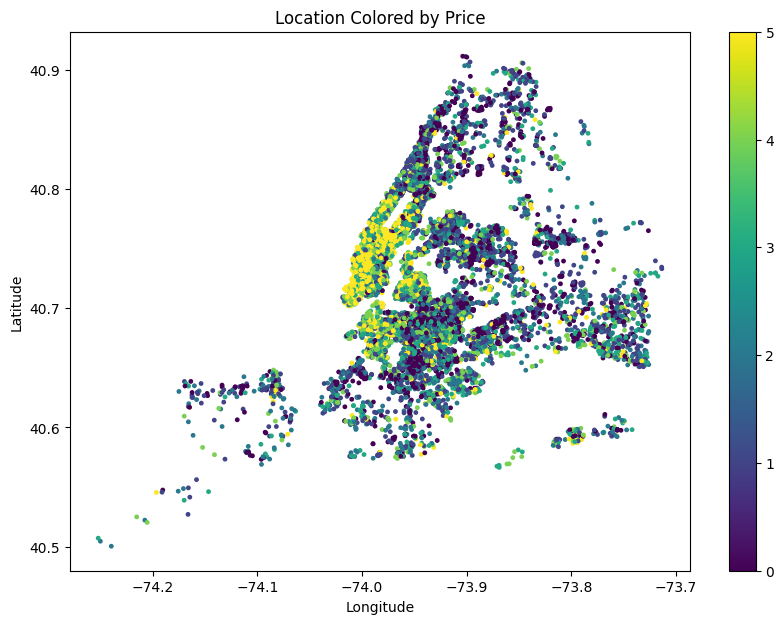

In [34]:
# display the longitude and latitude with scatter plot that is colored by the price
plt.figure(figsize=(10,7))
plt.scatter(train_data['longitude'], train_data['latitude'], c=train_target, cmap='viridis', s=6)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Location Colored by Price')
plt.show()

# cluster the longitude and latitude into 30 clusters
kmeans_location = KMeans(n_clusters=30, random_state=0).fit(train_data[['longitude','latitude']])
train_data['location'] = kmeans_location.labels_
test_data['location'] = kmeans_location.predict(test_data[['longitude','latitude']])

##### Datetime data:



In [35]:
# print maximum date for host_since
print(train_data['host_since'].max())

2024-08-31 00:00:00


In [36]:
# for the datatime object, we will replace it with year + month/12, ignoring the day, etc.
date_cols = ['host_since', 'first_review', 'last_review']

for col in date_cols:
    # eg. 2019-01-01 will be replaced with 2019 + 1/12 = 2019.0833
    train_data[col] = train_data[col].dt.year + train_data[col].dt.month/12
    test_data[col] = test_data[col].dt.year + test_data[col].dt.month/12
    # fill the missing value with 0 for clustering
    train_data[col] = train_data[col].fillna(0)
    test_data[col] = test_data[col].fillna(0)

#calculate the host duration from 2025
train_data['host_duration'] = 2025 - train_data['host_since']
test_data['host_duration'] = 2025 - test_data['host_since']

print(train_data.isnull().sum())

description                                        0
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                       0
latitude                                           0
longitude                                          0
host_since                                         0
host_response_time                                 0
host_response_rate                                 0
host_acceptance_rate                               0
host_is_superhost                                  0
host_listings_count                                0
host_total_listings_count                          0
host_verifications                                 0
host_has_profile_pic                               0
host_identity_verified                             0
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms   

##### bathroom shared?

I want to process the data['bathrooms_text'] on each row to see if there is 'shared' mentioned. If so, check the same row of data['bathrooms'] to see if the value is greater than 0. If both satisfied,  store in another data[''bathrooms_shared']  on the same row with 1, otherwise store 0.

In [37]:
train_data['bathrooms_text'].value_counts()

bathrooms_text
1 bath               8050
1 shared bath        2910
1 private bath       1404
2 baths              1261
2 shared baths        541
1.5 baths             444
1.5 shared baths      250
0 shared baths        243
2.5 baths             142
3 baths               124
0 baths               103
3 shared baths         52
4 baths                35
3.5 baths              32
Half-bath              22
2.5 shared baths       20
4 shared baths         13
Private half-bath      12
4.5 baths               6
Shared half-bath        5
5 baths                 4
3.5 shared baths        3
5 shared baths          3
10.5 baths              1
7 baths                 1
5.5 baths               1
6 shared baths          1
11.5 baths              1
6 baths                 1
4.5 shared baths        1
Name: count, dtype: int64

In [38]:
# Create a new column 'bathrooms_shared' based on the conditions specified
train_data['bathrooms_shared'] = train_data.apply(
    lambda row: 1 if ('shared' in str(row['bathrooms_text']).lower() and row['bathrooms'] > 0) else 0,
    axis=1
)

test_data['bathrooms_shared'] = test_data.apply(
    lambda row: 1 if ('shared' in str(row['bathrooms_text']).lower() and row['bathrooms'] > 0) else 0,
    axis=1
)

# Display the first few rows to verify the new column
print(train_data[['bathrooms', 'bathrooms_text', 'bathrooms_shared']].head())

# Drop the 'bathrooms_text' column
train_data = train_data.drop('bathrooms_text', axis=1)
test_data = test_data.drop('bathrooms_text', axis=1)

   bathrooms  bathrooms_text  bathrooms_shared
0        2.0         2 baths                 0
1        1.0  1 private bath                 0
2        1.0          1 bath                 0
3        1.5       1.5 baths                 0
4        1.0          1 bath                 0


#####  Per Accommodate feature

In [39]:
# calculate the bedroom, bed, and bathroom per accommodates can get
train_data['beds_per_accommodates'] = train_data['beds'] / train_data['accommodates']
train_data['bedrooms_per_accommodates'] = train_data['bedrooms'] / train_data['accommodates']
train_data['bathrooms_per_accommodates'] = train_data['bathrooms'] / train_data['accommodates']

test_data['beds_per_accommodates'] = test_data['beds'] / test_data['accommodates']
test_data['bedrooms_per_accommodates'] = test_data['bedrooms'] / test_data['accommodates']
test_data['bathrooms_per_accommodates'] = test_data['bathrooms'] / test_data['accommodates']


##### Amenities

In [40]:
#count the number of amenities
train_data['amenities'] = train_data['amenities'].apply(ast.literal_eval)
train_data['amenities_count'] = train_data['amenities'].apply(len)
test_data['amenities'] = test_data['amenities'].apply(ast.literal_eval)
test_data['amenities_count'] = test_data['amenities'].apply(len)

# Drop the 'amenities' column
train_data = train_data.drop('amenities', axis=1)
test_data = test_data.drop('amenities', axis=1)

In [41]:
# amenities_col = ['Lock on bedroom door', 'Hair dryer', 'Gym', 'Crib', 'Pets allowed',
#        'Elevator', 'Dishwasher', 'Shampoo', 'Iron', 'High chair', 'Essentials',
#        'Self check-in', 'Bed linens', 'Building staff', 'Coffee maker',
#        'Private entrance', 'Dryer – In unit', 'Washer – In unit', 'Hangers',
#        'Washer – In building', 'Dryer – In building', 'Hot tub',
#        'Wine glasses', 'Bathtub', 'Pack ’n play/Travel crib',
#        'Long term stays allowed', 'Air conditioning', 'Free dryer – In unit',
#        'Sound system', 'Babysitter recommendations']

# # Filter out the required amenities 
# train_data['amenities'] = train_data['amenities'].apply(lambda x: [amenity for amenity in x if amenity in amenities_col])
# test_data['amenities'] = test_data['amenities'].apply(lambda x: [amenity for amenity in x if amenity in amenities_col])
# # Use MultiLabelBinarizer to one-hot encode amenities
# mlb = MultiLabelBinarizer()
# encoded_amenities = pd.DataFrame(mlb.fit_transform(train_data['amenities']), columns=mlb.classes_, index=train_data.index)
# # Concatenate the original DataFrame with the new encoded amenities DataFrame
# train_data = pd.concat([train_data.drop(columns=['amenities']), encoded_amenities], axis=1)
# # Repeat the same process for the test data
# encoded_amenities = pd.DataFrame(mlb.transform(test_data['amenities']), columns=mlb.classes_, index=test_data.index)
# test_data = pd.concat([test_data.drop(columns=['amenities']), encoded_amenities], axis=1)


##### Review analysis

1. sentiment score for text review

In [42]:
train_review_pos_ratio = pd.read_csv('./Data_Preprocess/train_positive_ratio.csv')
test_review_pos_ratio = pd.read_csv('./Data_Preprocess/test_positive_ratio.csv')

# merge the review positive ratio
train_data = pd.concat([train_data,train_review_pos_ratio], axis=1)
test_data = pd.concat([test_data, test_review_pos_ratio], axis=1)

# drop the reviews column
train_data = train_data.drop('reviews', axis=1)
test_data = test_data.drop('reviews', axis=1)

2. Review occurrence ratio

In [43]:
# calculate the recent month review ratio, put 0 if there is no review
train_data['recent_month_review_ratio'] = train_data.apply(
    lambda row: row['number_of_reviews_l30d'] / row['number_of_reviews'] if row['number_of_reviews'] > 0 else 0,
    axis=1)
test_data['recent_month_review_ratio'] = test_data.apply( 
    lambda row: row['number_of_reviews_l30d'] / row['number_of_reviews'] if row['number_of_reviews'] > 0 else 0,
    axis=1)
# recent year review ratio, put 0 if there is no review
train_data['recent_year_review_ratio'] = train_data.apply(
    lambda row: row['number_of_reviews_ltm'] / row['number_of_reviews'] if row['number_of_reviews'] > 0 else 0,
    axis=1)
test_data['recent_year_review_ratio'] = test_data.apply(
    lambda row: row['number_of_reviews_ltm'] / row['number_of_reviews'] if row['number_of_reviews'] > 0 else 0,
    axis=1)

#### 1.3 Advanced conversion

In [44]:
print(train_data.dtypes)

description                                       int32
neighbourhood_cleansed                           object
neighbourhood_group_cleansed                     object
latitude                                        float64
longitude                                       float64
host_since                                      float64
host_response_time                               object
host_response_rate                              float64
host_acceptance_rate                            float64
host_is_superhost                                  bool
host_listings_count                             float64
host_total_listings_count                       float64
host_verifications                               object
host_has_profile_pic                               bool
host_identity_verified                             bool
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms    

In [45]:
# encode the object columns
object_cols = train_data.select_dtypes(include=[object]).columns
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

ordinal_encoder.fit(train_data[object_cols])
train_data[object_cols] = ordinal_encoder.transform(train_data[object_cols])
test_data[object_cols] = ordinal_encoder.transform(test_data[object_cols])


In [46]:
summary = pd.DataFrame({
    'DataType': train_data.dtypes,
    'Missing': train_data.isnull().sum()
})

# Print the combined DataFrame
print(summary)

                                             DataType  Missing
description                                     int32        0
neighbourhood_cleansed                        float64        0
neighbourhood_group_cleansed                  float64        0
latitude                                      float64        0
longitude                                     float64        0
host_since                                    float64        0
host_response_time                            float64        0
host_response_rate                            float64        0
host_acceptance_rate                          float64        0
host_is_superhost                                bool        0
host_listings_count                           float64        0
host_total_listings_count                     float64        0
host_verifications                            float64        0
host_has_profile_pic                             bool        0
host_identity_verified                           bool  

In [ ]:
# output the processed data
train_data = pd.concat([train_target, train_data], axis=1)
test_data = pd.concat([test_id, test_data], axis=1)
train_data.to_csv('./Data_Processed/train_processed.csv', index=False)
test_data.to_csv('./Data_Processed/test_processed.csv', index=False)